Train an AE on quarks and gluons, to identify W, Z and t jets as anomalies. For this task, you should provide a successful training history, a plot showing the distribution of the loss for the standard jets and for the three anomaly classes, and a ROC curve plot with the three anomaly classes.

---

Trained on paid colab with L4 GPU

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Reshape, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError
import h5py
import pandas as pd
import glob
from matplotlib.colors import LogNorm


In [3]:
# for latex issue
!sudo apt-get update
!sudo apt-get install texlive-latex-recommended dvipng texlive-latex-extra texlive-fonts-recommended cm-super


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,549 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,364 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packa

In [4]:
# Get the data
#! git clone https://github.com/pierinim/tutorials.git
#! ls tutorials/Data/JetDataset/

!wget https://zenodo.org/api/records/3602254/files/hls4ml_LHCjet_100p_val.tar.gz/content -O zenodo.tar.gz
!tar -xzf zenodo.tar.gz
!ls val/

--2024-12-15 11:45:50--  https://zenodo.org/api/records/3602254/files/hls4ml_LHCjet_100p_val.tar.gz/content
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1051808139 (1003M) [application/octet-stream]
Saving to: ‘zenodo.tar.gz’

zenodo.tar.gz       100%[===================>]   1003M  19.7MB/s    in 54s     

2024-12-15 11:46:44 (18.7 MB/s) - ‘zenodo.tar.gz’ saved [1051808139/1051808139]

jetImage_7_100p_0_10000.h5	jetImage_8_100p_0_10000.h5	jetImage_9_100p_0_10000.h5
jetImage_7_100p_10000_20000.h5	jetImage_8_100p_10000_20000.h5	jetImage_9_100p_10000_20000.h5
jetImage_7_100p_30000_40000.h5	jetImage_8_100p_20000_30000.h5	jetImage_9_100p_30000_40000.h5
jetImage_7_100p_40000_50000.h5	jetImage_8_100p_30000_40000.h5	jetImage_9_100p_40000_50000.h5
jetImage_7_100p_50000_60000.h5	jetImage_8_100p_40000_50000.h5	jetImage_9_100p_50000

In [5]:
target = np.array([])
jetImage = np.array([])

# if we cannot load all data on Colab, we just take a few of them
#datafiles = ['tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5','tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5','tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5','tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5','tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5']

# Too much memory usage, hence, only jetImage 7 and 8
for fileIN in glob.glob("val/*[7|8]*100p*h5"):
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myjetImage = np.array(f.get("jetImage"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetImage = np.concatenate([jetImage, myjetImage], axis=0) if jetImage.size else myjetImage
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
print(target.shape, jetImage.shape)

Appending val/jetImage_8_100p_50000_60000.h5
Appending val/jetImage_7_100p_80000_90000.h5
Appending val/jetImage_7_100p_0_10000.h5
Appending val/jetImage_8_100p_60000_70000.h5
Appending val/jetImage_7_100p_60000_70000.h5
Appending val/jetImage_7_100p_50000_60000.h5
Appending val/jetImage_8_100p_70000_80000.h5
Appending val/jetImage_7_100p_70000_80000.h5
Appending val/jetImage_8_100p_30000_40000.h5
Appending val/jetImage_8_100p_0_10000.h5
Appending val/jetImage_8_100p_20000_30000.h5
Appending val/jetImage_8_100p_10000_20000.h5
Appending val/jetImage_7_100p_30000_40000.h5
Appending val/jetImage_8_100p_40000_50000.h5
Appending val/jetImage_7_100p_10000_20000.h5
Appending val/jetImage_7_100p_40000_50000.h5
(160000, 5) (160000, 100, 100)


The ground truth is one-hot encoded in the ['j_g', 'j_q', 'j_w', 'j_z', 'j_t] format, so that
- [1, 0, 0, 0, 0] for gluons
- [0, 1, 0, 0, 0] for quarks
- [0, 0, 1, 0, 0] for Ws
- [0, 0, 0, 1, 0] for Zs
- [0, 0, 0, 0, 1] for tops

The information is contained at the end of the feature vector

In [6]:
# separate normal from anomalies
X_normal = jetImage[np.argmax(target,axis=1) < 2]

X_anomaly_w = jetImage[np.argmax(target,axis=1) == 2]
X_anomaly_z = jetImage[np.argmax(target,axis=1) == 3]
X_anomaly_t = jetImage[np.argmax(target,axis=1) == 4]

# Add channel dimension
X_normal = np.expand_dims(X_normal, axis=-1)
X_anomaly_w = np.expand_dims(X_anomaly_w, axis=-1)
X_anomaly_z = np.expand_dims(X_anomaly_z, axis=-1)
X_anomaly_t = np.expand_dims(X_anomaly_t, axis=-1)

print(len(X_normal), len(X_anomaly_w), len(X_anomaly_z), len(X_anomaly_t))
del jetImage, target

63353 32212 32088 32347


In [7]:
# Split data into training (60%), test (20%), and validation (20%)
X_train_normal, X_tmp = train_test_split(X_normal, test_size=0.4, random_state=31)
X_val_normal, X_test_normal = train_test_split(X_tmp, test_size=0.5, random_state=31)

print(X_train_normal.shape, X_val_normal.shape, X_test_normal.shape)
del X_tmp

(38011, 100, 100, 1) (12671, 100, 100, 1) (12671, 100, 100, 1)


In [8]:
def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(10, (5, 5), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(15, (5, 5), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(20, (5, 5), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((5, 5), padding='same')(x)

    x = Conv2D(25, (5, 5), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((5, 5), padding='same')(x)

    x = Flatten()(x)
    x = Dense(5,"relu")(x)
    x = Dense(25,"relu")(x)
    x = Reshape((1,1,25))(x)

    # Decoder
    x = UpSampling2D((5, 5))(x)
    x = Conv2D(25, (5, 5), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D((5, 5))(x)
    x = Conv2D(20, (5, 5), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(15, (5, 5), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(10, (5, 5), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    output = Conv2D(1, (5, 5), activation='relu', padding='same')(x)

    autoencoder = Model(input_img, output)
    return autoencoder

In [9]:
autoencoder = build_autoencoder(X_train_normal[0].shape)
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

In [10]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 100, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 100, 100, 10)        │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 100, 10)        │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 100, 100, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 15)          │           3,765 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 50, 50, 15)          │              60 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 50, 50, 15)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 15)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 25, 20)          │           7,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 25, 25, 20)          │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 25, 25, 20)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 20)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 5, 5, 25)            │          12,525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 5, 5, 25)            │             100 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 5, 5, 25)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 25)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             130 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 64,606 (252.37 KB)

 Trainable params: 64,326 (251.27 KB)

 Non-trainable params: 280 (1.09 KB)

In [11]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')

In [12]:
history = autoencoder.fit(X_train_normal, X_train_normal, validation_data=(X_val_normal, X_val_normal), epochs=50, batch_size=64, shuffle=True,
                          callbacks=[early_stopping])

Epoch 1/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - loss: 19.3710 - val_loss: 7.4542
Epoch 2/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 6.8289 - val_loss: 7.5233
Epoch 3/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 5.6864 - val_loss: 5.6316
Epoch 4/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 4.9243 - val_loss: 4.9126
Epoch 5/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 4.4848 - val_loss: 4.6289
Epoch 6/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 4.2734 - val_loss: 3.9328
Epoch 7/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 4.0401 - val_loss: 3.8276
Epoch 8/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 3.9226 - val_loss: 4.3396
Epoch 9/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 3.8239 - val_loss: 4.0440
Epoch 10/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 3.7129 - val_loss: 4.0213
Epoch 11/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 3.6159 - val_loss: 4.2572
Epoch 12/50
594/594 ━━━━━━━━━

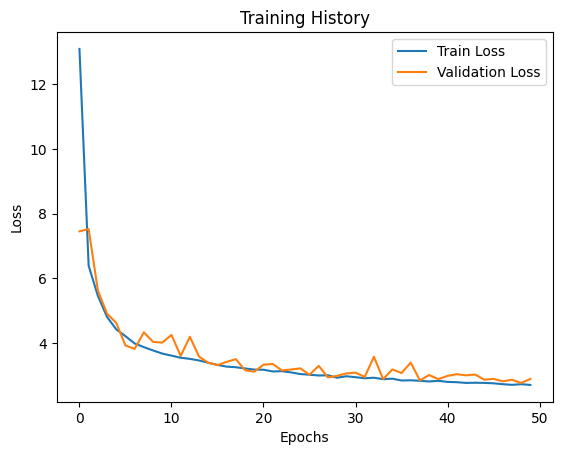

In [13]:
# Plot the training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1403/1403 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


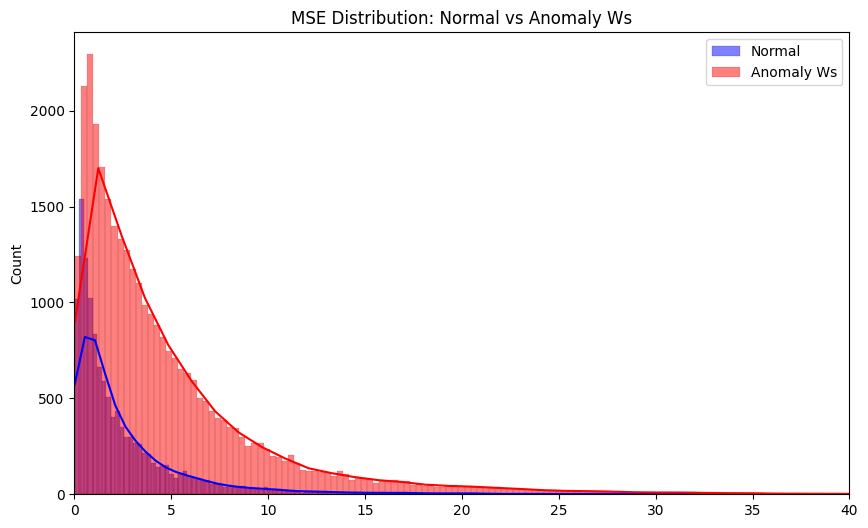

1399/1399 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


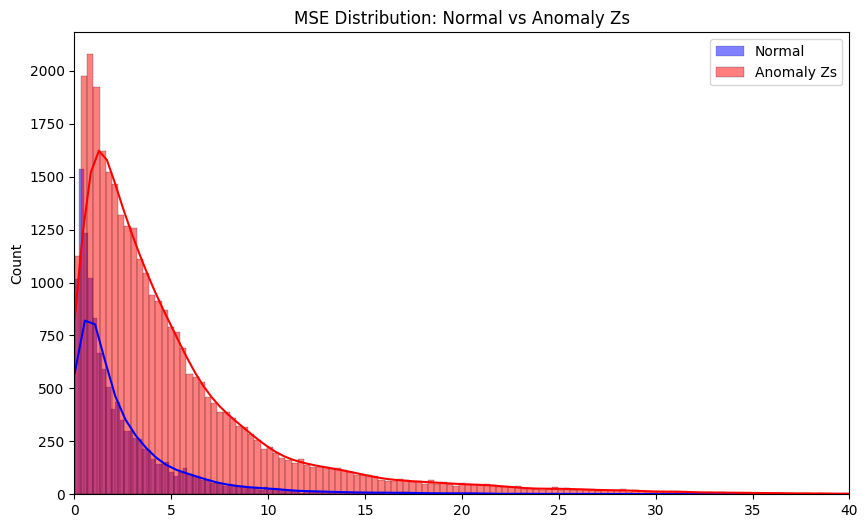

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


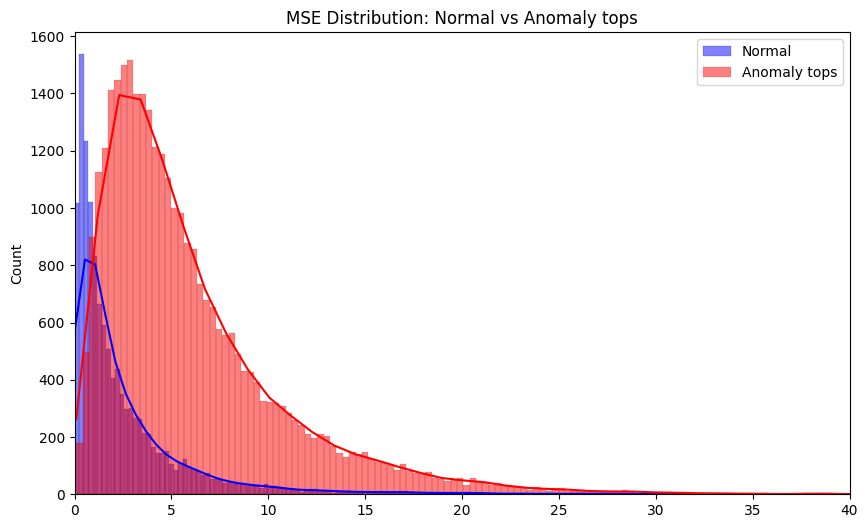

In [14]:
anomalies = [X_anomaly_w, X_anomaly_z, X_anomaly_t]
ano_labels = ["Ws", "Zs", "tops"]
mse_vals = []
y_vals = []

for idx, anomaly in enumerate(anomalies):
  # Combine validation set with anomalies (label 0 for background, 1 for anomalies)
  X_val = np.concatenate([X_val_normal, anomaly], axis=0)
  y_val = np.concatenate([np.zeros(len(X_val_normal)), np.ones(len(anomaly))], axis=0)
  y_vals.append(y_val)

  # Calculate MSE for the validation dataset
  x_out_val = autoencoder.predict(X_val)
  mse_val = np.mean(np.square(X_val - x_out_val), axis=(1, 2, 3))
  mse_vals.append(mse_val)

  # Plot the distribution of MSE for normal vs anomalies
  plt.figure(figsize=(10,6))
  sns.histplot(mse_val[y_val == 0], label='Normal', color='blue', kde=True)
  sns.histplot(mse_val[y_val == 1], label=f'Anomaly {ano_labels[idx]}', color='red', kde=True)
  plt.xlim([0.0, 40.0])
  plt.title(f'MSE Distribution: Normal vs Anomaly {ano_labels[idx]}')
  plt.legend()
  plt.show()

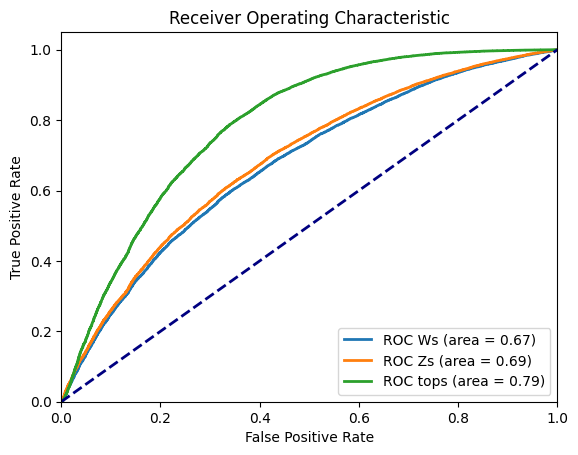

In [15]:
# ROC curve
plt.figure()

for idx, label in enumerate(ano_labels):
  fpr, tpr, thresholds = roc_curve(y_vals[idx], mse_vals[idx])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, lw=2, label=f'ROC {label} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


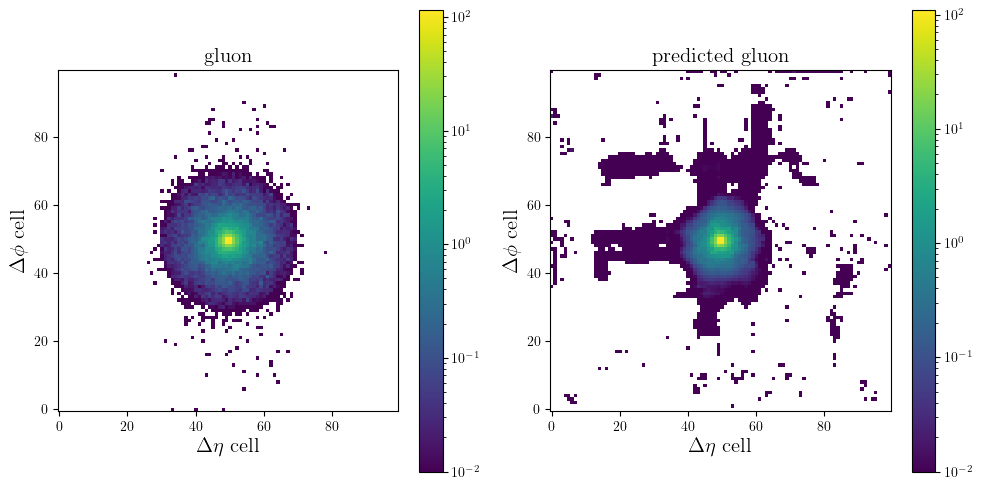

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


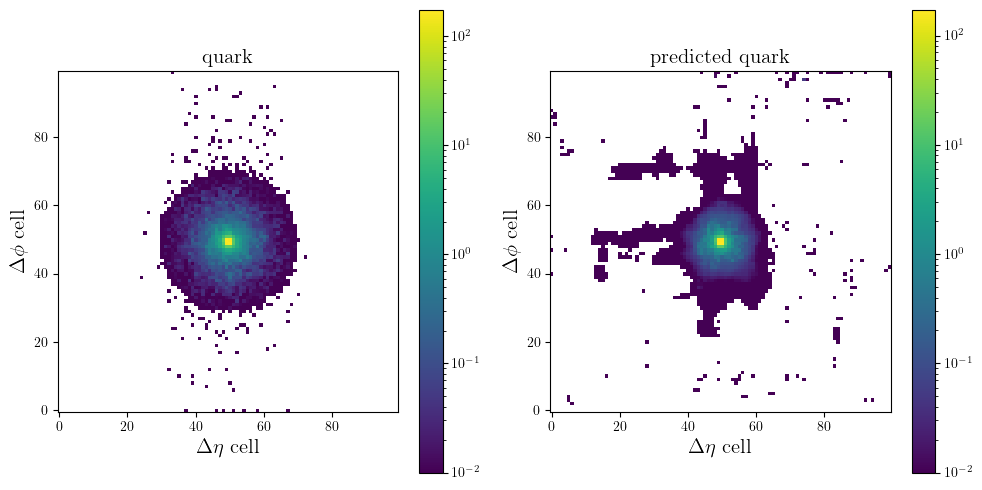

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


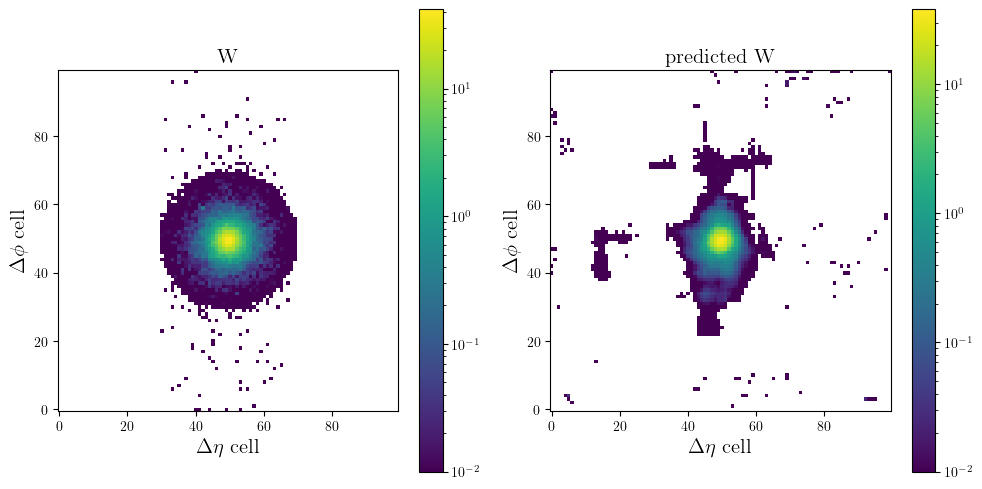

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


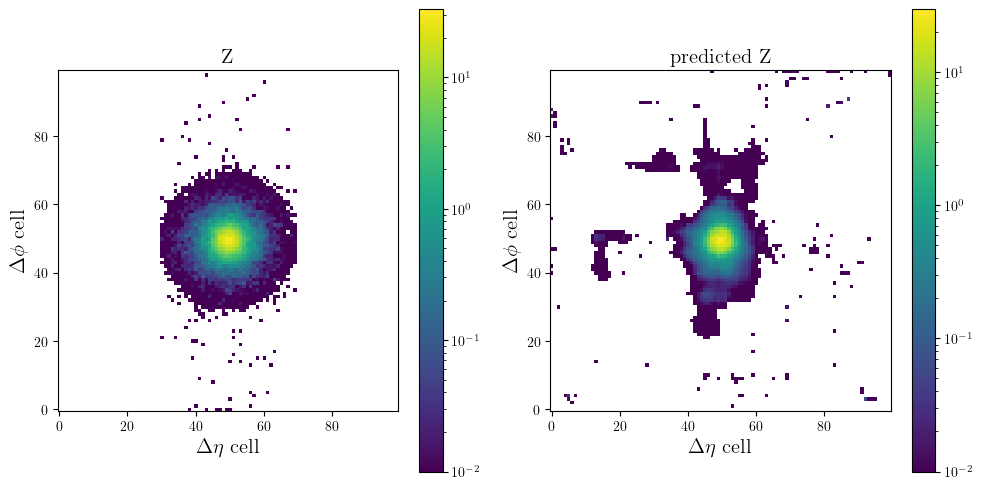

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


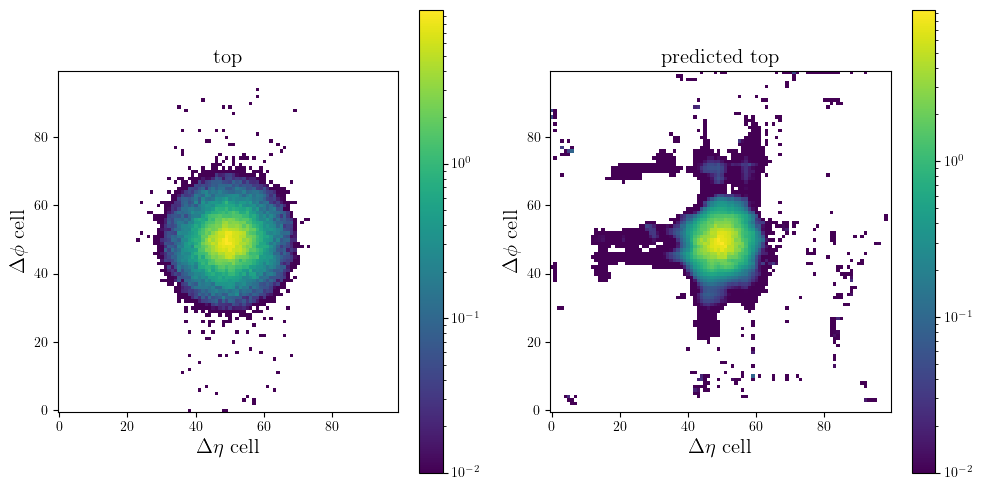

In [16]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def display_img(name,arr):
  arr = np.expand_dims(arr, axis=-1)
  predicted = autoencoder.predict(arr)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

  SUM_Image = np.sum(arr, axis = 0)
  im1 = ax1.imshow(SUM_Image/float(arr.shape[0]), origin='lower',norm=LogNorm(vmin=0.01))
  fig.colorbar(im1, ax=ax1)

  predicted_SUM_Image = np.sum(predicted, axis = 0)
  im2 = ax2.imshow(predicted_SUM_Image/float(predicted.shape[0]), origin='lower',norm=LogNorm(vmin=0.01))
  fig.colorbar(im2, ax=ax2)

  ax1.set_title(name, fontsize=15)
  ax1.set_xlabel("$\Delta\eta$ cell", fontsize=15)
  ax1.set_ylabel("$\Delta\phi$ cell", fontsize=15)

  ax2.set_title(f"predicted {name}", fontsize=15)
  ax2.set_xlabel("$\Delta\eta$ cell", fontsize=15)
  ax2.set_ylabel("$\Delta\phi$ cell", fontsize=15)

  plt.tight_layout()
  plt.show()

singleFile = h5py.File('val/jetImage_7_100p_30000_40000.h5')
image = np.array(singleFile.get('jetImage'))
singleTarget = np.array(singleFile.get('jets')[0:,-6:-1])
image_g = image[np.argmax(singleTarget, axis=1) == 0]
image_q = image[np.argmax(singleTarget, axis=1) == 1]
image_w = image[np.argmax(singleTarget, axis=1) == 2]
image_z = image[np.argmax(singleTarget, axis=1) == 3]
image_t = image[np.argmax(singleTarget, axis=1) == 4]

jets = [["gluon", image_g], ["quark", image_q], ["W", image_w], ["Z", image_z], ["top", image_t]]

for label, img in jets:
  display_img(label, img)


